<a href="https://colab.research.google.com/github/sergekamanzi/Fraud-Detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
pip install focal-loss


In [26]:
# Import Required Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Nadam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from focal_loss import BinaryFocalLoss
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
data = pd.read_csv('/content/fraud detection.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [28]:
data.shape

(1280499, 11)

In [29]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'BMIcase' and 'Gender' columns
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

In [30]:
# Feature Engineering: Create meaningful features
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)  # Avoid division by zero
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

In [31]:
%%capture
data.head()

In [32]:
# Handle missing values (impute with median)
data.fillna(data.median(), inplace=True)

In [33]:
%%capture
# Checking for NAN values
data.isna().sum()

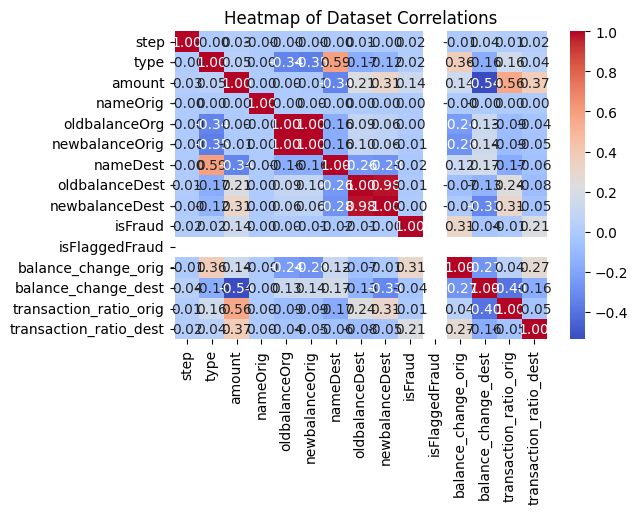

In [34]:
correlation_matrix = data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Heatmap of Dataset Correlations')
plt.show()

In [35]:
# Drop 'nameDest' as it doesn't provide useful information
data.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

In [36]:
# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

In [37]:
# to see how many 1s and 0s in isFraud
fraud_count = data['isFraud'].value_counts()[1]
print(f"{fraud_count} fraudulent transactions in the dataset.")
fraud_count1 = data['isFraud'].value_counts()[0]
print(f"{fraud_count1} non fraudulent transactions in the dataset.")

1542 fraudulent transactions in the dataset.
1278957 non fraudulent transactions in the dataset.


In [38]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust strategy as needed
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [40]:
# Define the Model with Nadam, L2 Regularization & Batch Normalization
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile model with Nadam and Focal Loss
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=BinaryFocalLoss(gamma=2), metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
# Train the Model
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=50, batch_size=256,
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9349 - loss: 0.2282 - val_accuracy: 0.9866 - val_loss: 0.0163
Epoch 2/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - accuracy: 0.9715 - loss: 0.0287 - val_accuracy: 0.9655 - val_loss: 0.0343
Epoch 3/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9726 - loss: 0.0280 - val_accuracy: 0.9856 - val_loss: 0.0157
Epoch 4/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.9730 - loss: 0.0276 - val_accuracy: 0.9827 - val_loss: 0.0215
Epoch 5/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.9726 - loss: 0.0280 - val_accuracy: 0.9895 - val_loss: 0.0187
Epoch 6/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9727 - loss: 0.0279 - val_accuracy: 0.9860 - val_loss: 0.0173
Epoch 7/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9715 - loss: 0.0284 - val_accuracy: 0.9619 - val_loss: 0.0335
Epoch 8/50
5246/5246 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9717 - loss: 0

In [42]:
# Evaluate the model on test set
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

6003/6003 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [43]:
# Calculate Accuracy and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.9714
F1 Score: 0.0757

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    191843
         1.0       0.04      0.97      0.08       232

    accuracy                           0.97    192075
   macro avg       0.52      0.97      0.53    192075
weighted avg       1.00      0.97      0.98    192075



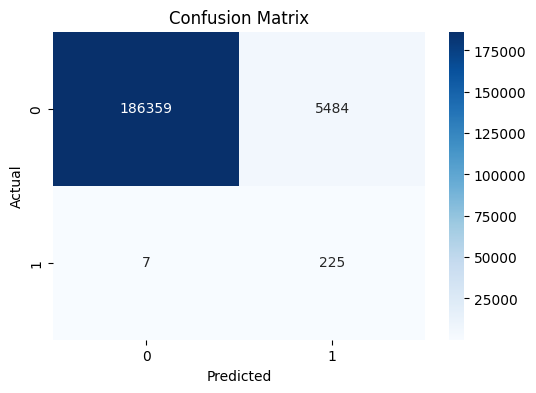

In [44]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()